In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tesla-stock-price:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1007%2F1814%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240319%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240319T041105Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D60d80f719b1cf002927dd850c16571c427630804b60369b2234a0ff6773a1b4dd0142f7a04e60af3ce50d964a4f172453eeb62cdddcad206dc6cb1b0feb97a1507e2dc9b03b3aba7c2cb21f192f8517b8da2a9330a3e9ac0346e229b8a7d5d0f5b2f6e8c8fc70efcefc03928173d09b493d5ceeb61cf4965c57fdca9b5a09effb2b9654a5c6086f05c3567d63be776ff3391a5c9edd11829808bc25614356b07bd651c1c3c505276b8646094ab4fbfa5982dfa87961533edead181b228051653965247226d69b6295fad1533c28aa81dd8c1e1476a977960dd7a794c5099f2a7b6f7010670d901f340833193bed03cf1bafd9a2c4d3e274eb573940fe16b89d4,sandp500:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1908%2F17155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240319%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240319T041105Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D109d41e859ef7a11b6b6945df08f5ee9d8cfe104bd055f367cd75203fa11aac8f2f8176234329d6a62dc9fedc1919d0436920b4ec2714e83aacfcc253f7df875829a94dd52c8c2a1567ffa01d021fa3780e2731d33d4fec88803a7a640677760570ae81f775b96aee54fb1650079513cb9fa7eb5421810c889649ac745db8674e70620b223081f67ea087ad5ba4799eb69a11e33814db00f87cfd364f1d38f66aa5d144220b62552d0413ad8f5f27ba3678f55cff8e646d6f77ef6e1776ade402a68cc6167e3c3091c9039b7d8b7ad6a8816dc0671c3153361afed3aff2774330eced097a45f194ebdd33d3e5737767289c5c727124e1f33b2b2eb2a41bb7ded,amzn-dpz-btc-ntfx-adjusted-may-2013may2019:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F195545%2F433077%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240319%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240319T041105Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db9d35bb2bc5c0534f415298db191c34b503004453ce7d00f7815dec9297220d6dc5399883924978a1a9dc0ab26ff034f5c9a4f632f9cdbfb3cc235e73c8ce2c027e8a95396cb1ae15bf3b057f6c22dbb28c3717ad370dd2062aa59f669740e4fecc5e26642b66052777cac96a0d4ee1601db3e68cc38dacbc6b67952852b805f6bc9e287163b88bb3e3c712fbfe02578bab9236185ee0d2e3085fae9e1f3d8adc5373d5f902d171d7d9a8ce5eeded7d996d3b81c354a08b3ce32771e42bb88156351fafce38f270e038631f6a82f9ee63aff2a361ae65906559733096dd596a97da7a121d1f814cca146e36679c406eb2b3fadfa6097f81b55b0b34497ccc062,apple-aapl-historical-stock-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F533900%2F976925%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240319%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240319T041105Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44c5b6ec93a9a793431cdbf29e8aca29fd53adfc5b84161684703170be795e9fe70a532cd52719dc5d0bdb24144691d4b77c0c0285eb7c9ab33e7143f7811a90f9378916f8cd32702f6bc4400a312d061fb5c303342b7b554724b02245f641c1621566546e0c943c7a850fd637778713b67d09084114ddc0e2ea80343a327ced1b5ff01f992a280b13ac3b663d862310bd845864653c12c194dae7ea3a90af34bb2101f078aa41c6b5e5af47780128c27fc28b717a280a11e2fb7c95548d85c52d14bf6f0552a5349cbb7b5e9a302b80777ae79f90c03be6758f8f19bb86a0512216fcf415c997adf475fb6f1c658503498b2064ca96307f5866e25cb3bab115'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34499 bytes downloaded
Downloaded and uncompressed: tesla-stock-price
[==================================================] 20283917 bytes downloaded
Downloaded and uncompressed: sandp500
[==================================================] 30437 bytes downloaded
Downloaded and uncompressed: amzn-dpz-btc-ntfx-adjusted-may-2013may2019
[==================================================] 50651 bytes downloaded
Downloaded and uncompressed: apple-aapl-historical-stock-data
Data source import complete.


In [2]:
#1. What was the change in price of the stock overtime?

In [3]:
!pip install -q yfinance

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-03-05,176.929993,176.929993,173.300003,174.119995,174.119995,37228300,AMAZON
2024-03-06,175.539993,176.460007,173.259995,173.509995,173.509995,32090900,AMAZON
2024-03-07,174.830002,177.990005,173.720001,176.820007,176.820007,34063300,AMAZON
2024-03-08,176.440002,178.789993,174.330002,175.350006,175.350006,37853500,AMAZON
2024-03-11,174.309998,174.470001,171.470001,171.960007,171.960007,28484800,AMAZON
2024-03-12,173.500000,176.759995,171.979996,175.389999,175.389999,36610600,AMAZON
2024-03-13,175.899994,177.619995,175.550003,176.559998,176.559998,30772600,AMAZON
2024-03-14,177.690002,179.529999,176.470001,178.750000,178.750000,43705800,AMAZON
2024-03-15,176.639999,177.929993,173.899994,174.419998,174.419998,72115500,AMAZON


In [5]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,180.289204,181.749841,178.966773,180.456693,179.968814,5.740706e+07
std,10.092829,9.939691,10.008015,9.940297,10.046009,1.705579e+07
min,155.070007,157.820007,154.149994,157.399994,156.564301,2.404830e+07
25%,173.035004,174.264999,171.745003,173.470001,172.788750,4.678545e+07
50%,180.669998,182.229996,178.550003,180.710007,180.238220,5.337730e+07
75%,189.294998,189.990005,187.695000,189.334999,188.909805,6.344460e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.366826e+08


In [6]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2023-03-20 to 2024-03-18
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Close         251 non-null    float64
 4   Adj Close     251 non-null    float64
 5   Volume        251 non-null    int64  
 6   company_name  251 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.7+ KB


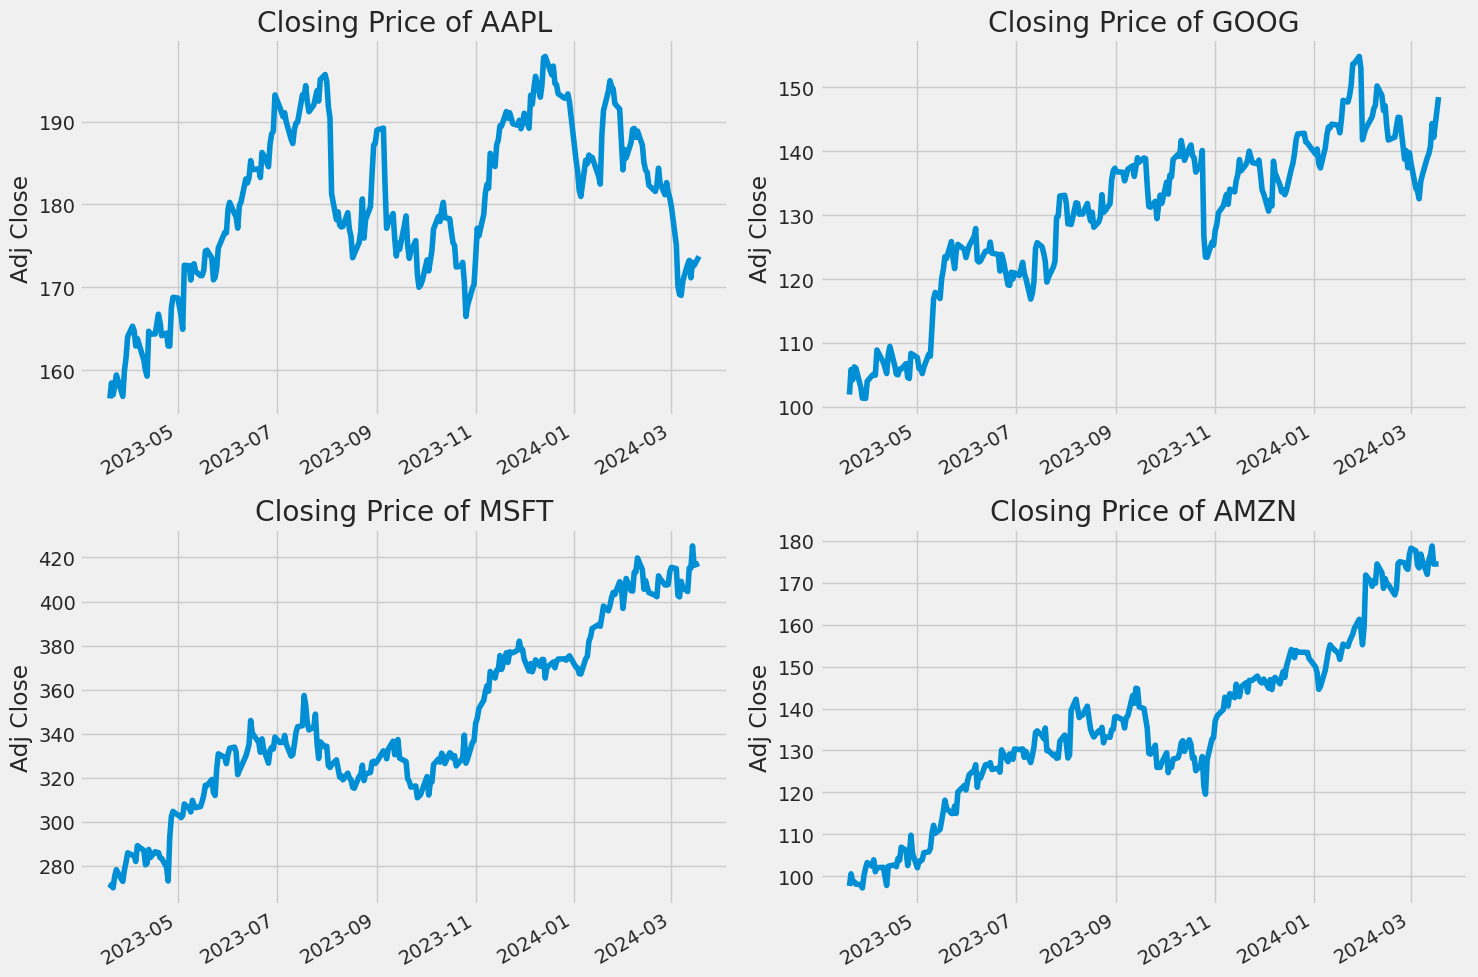

In [7]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

In [8]:
#2. What was the moving average of the various stocks?

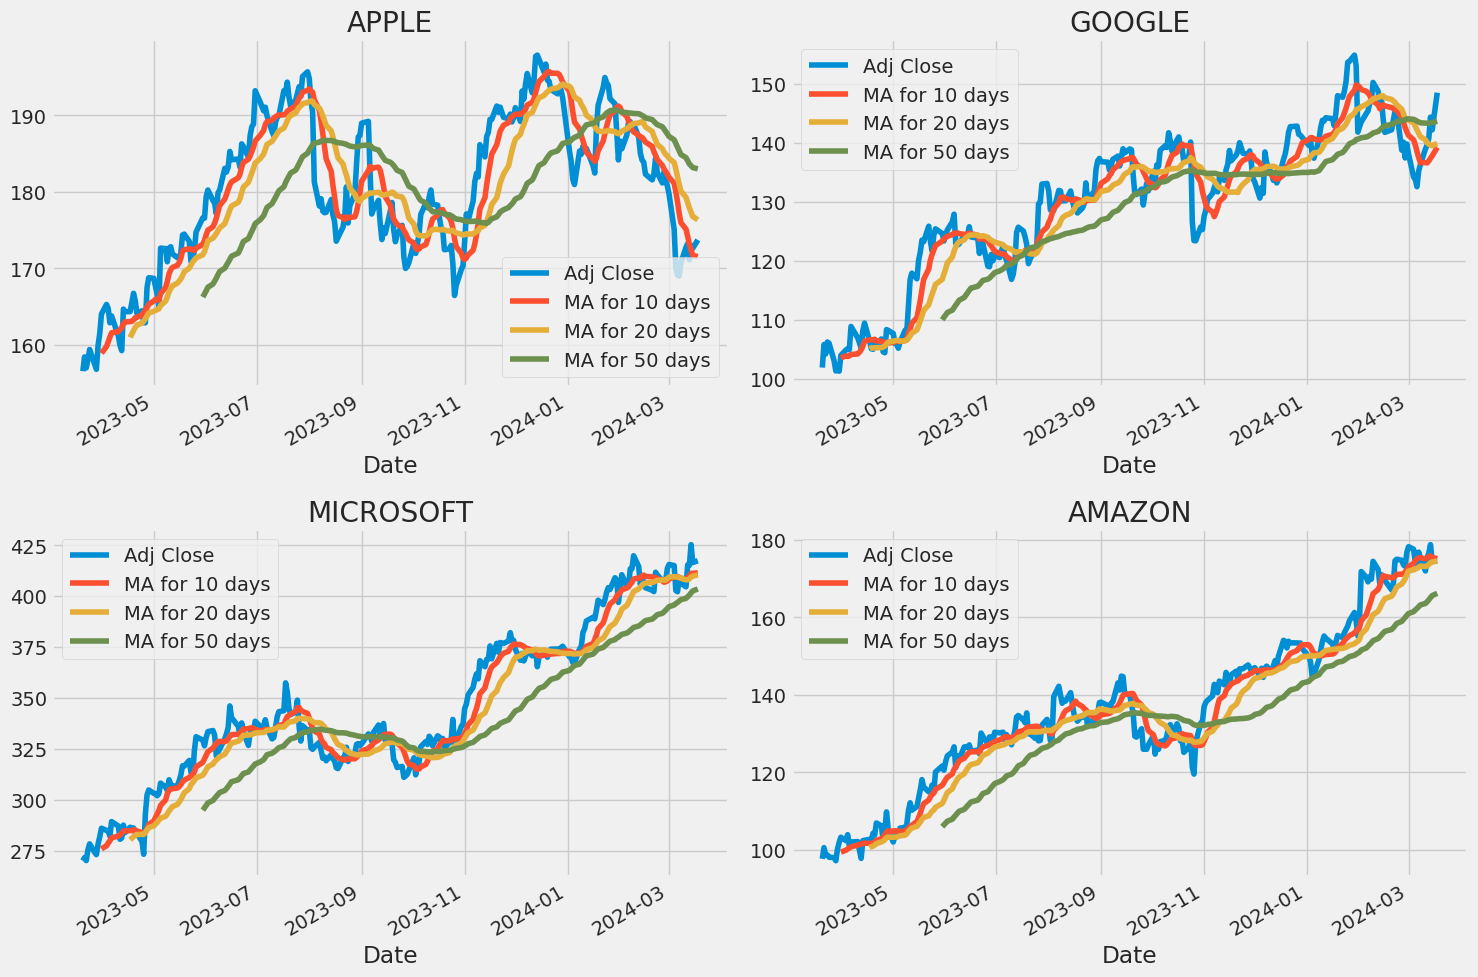

In [9]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

In [10]:
#3. What was the daily return of the stock on average?

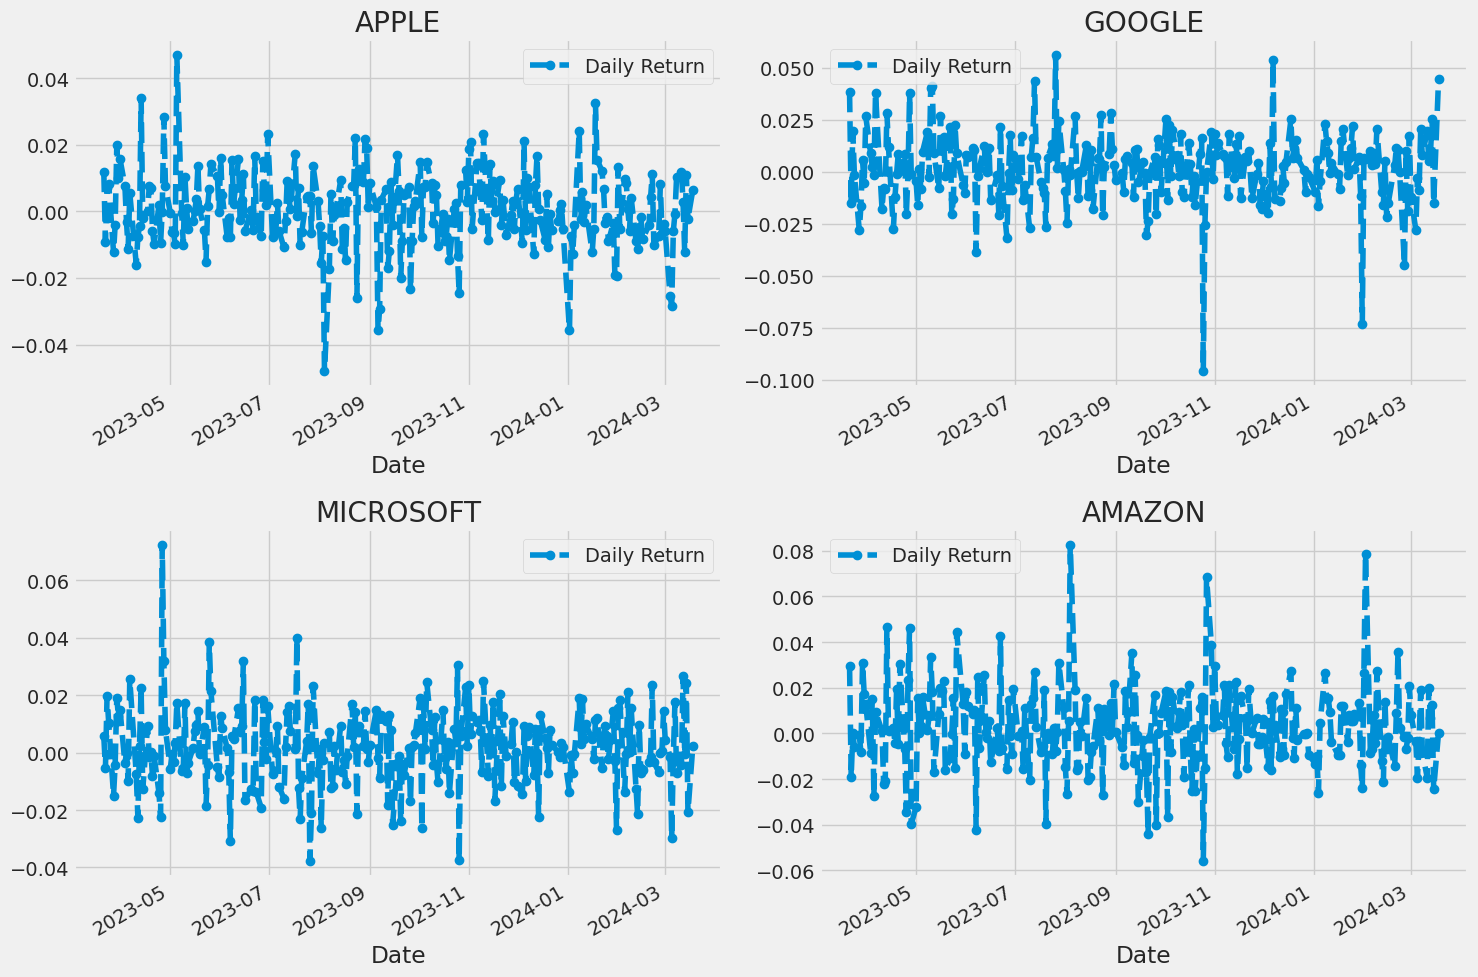

In [11]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

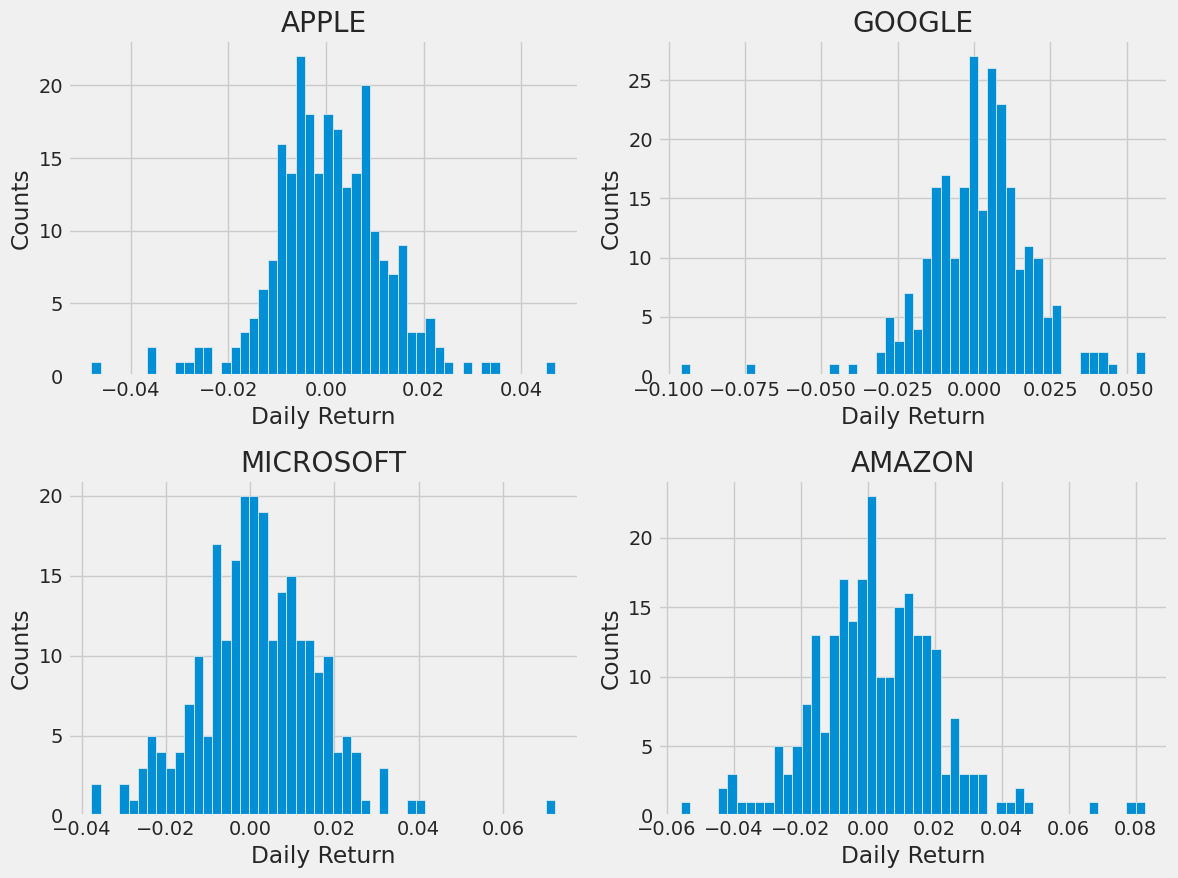

In [12]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

In [13]:
#4. What was the correlation between different stocks closing prices?

In [14]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-03-20,NaN,NaN,NaN,NaN
2023-03-21,0.011944,0.029680,0.038360,0.005694
2023-03-22,-0.009103,-0.018984,-0.015306,-0.005442
2023-03-23,0.006969,0.000101,0.019574,0.019722
2023-03-24,0.008306,-0.005876,-0.001882,0.010480


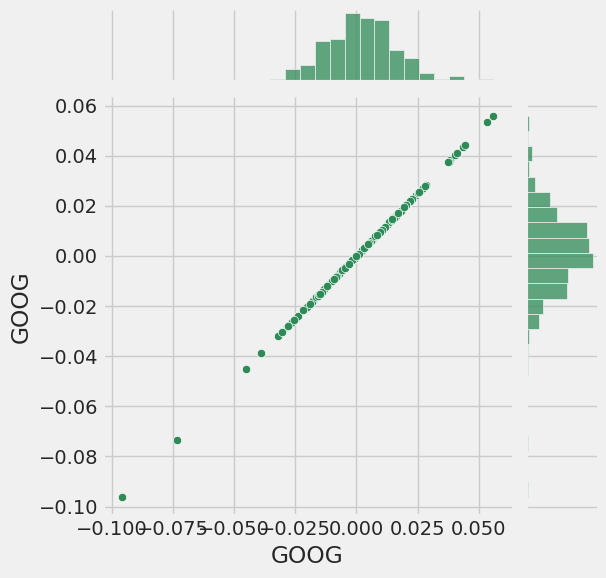

In [15]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

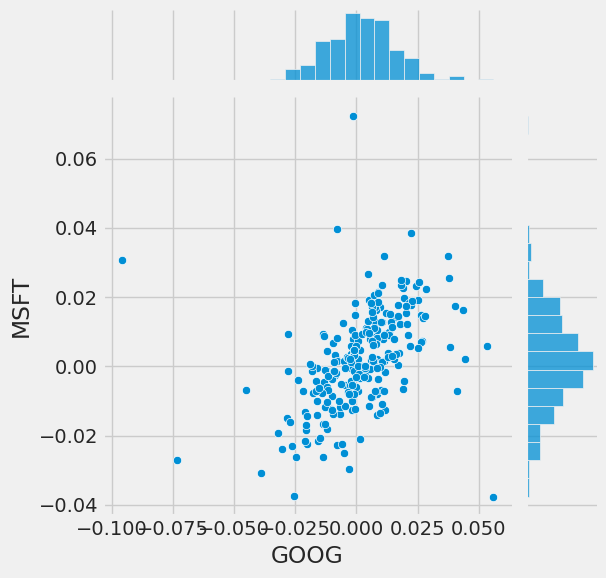

In [16]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

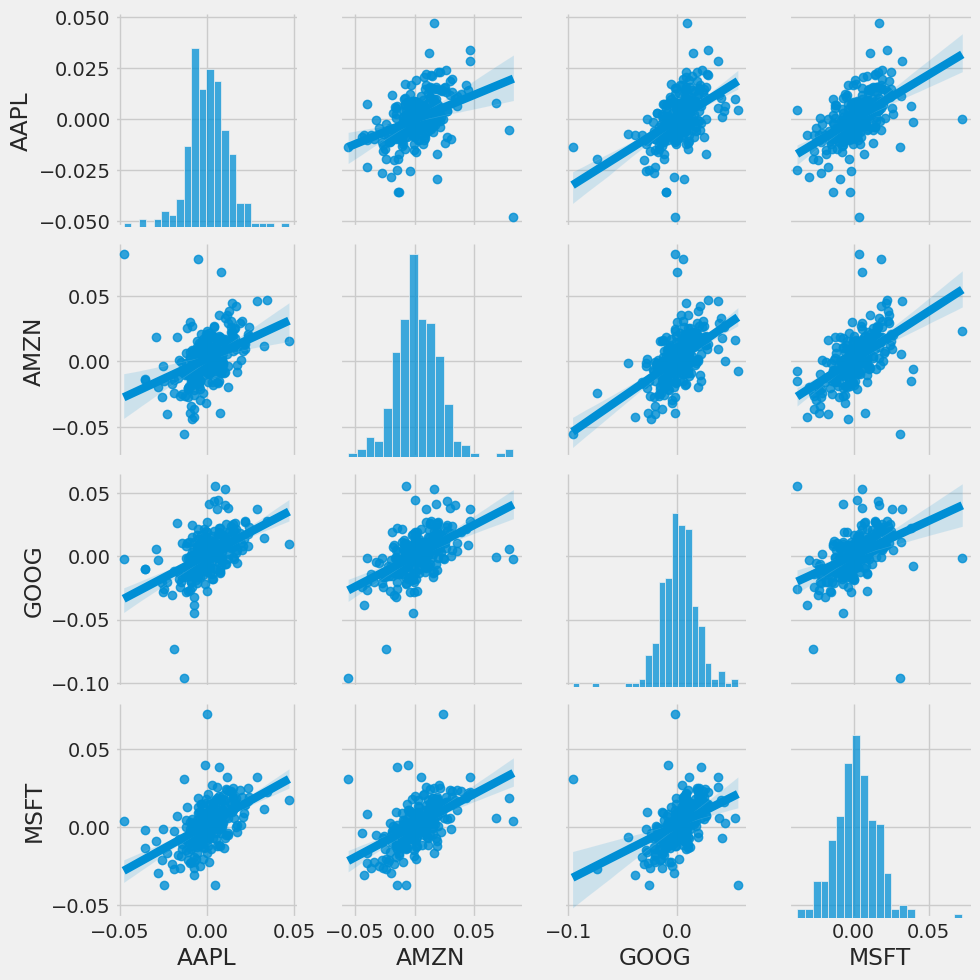

In [17]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

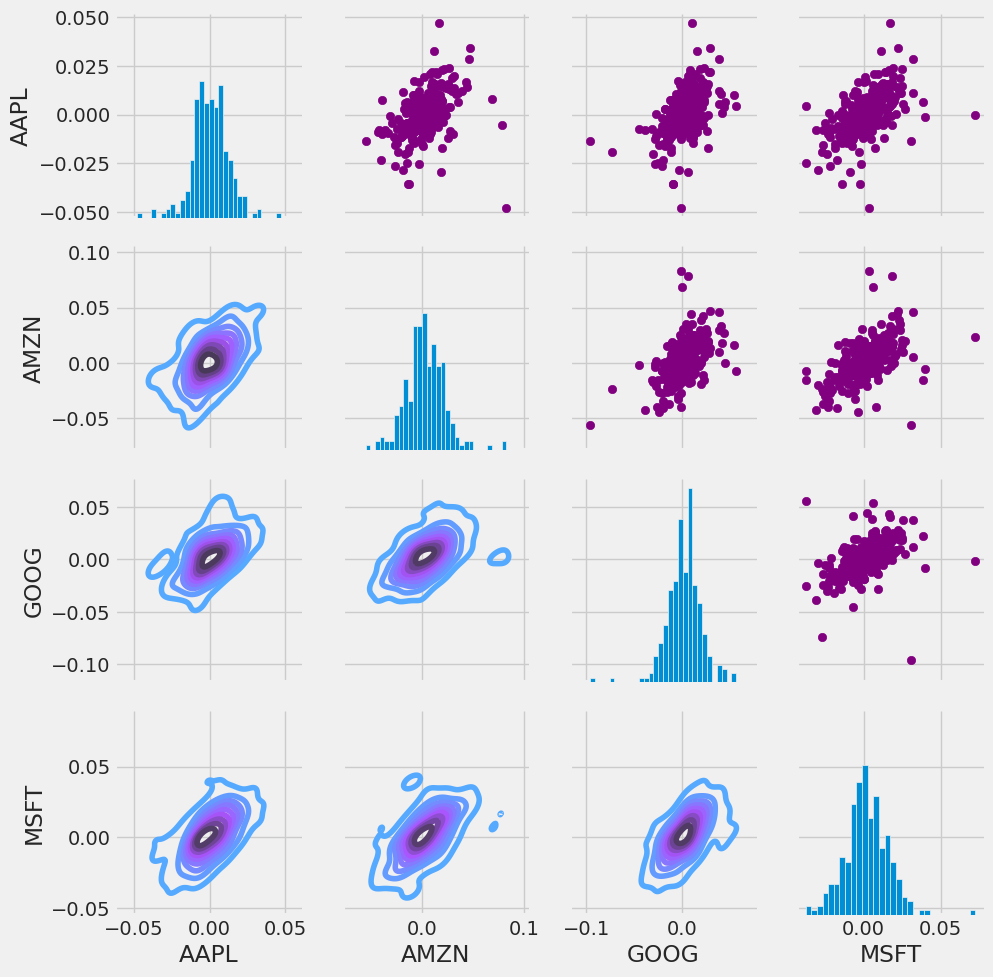

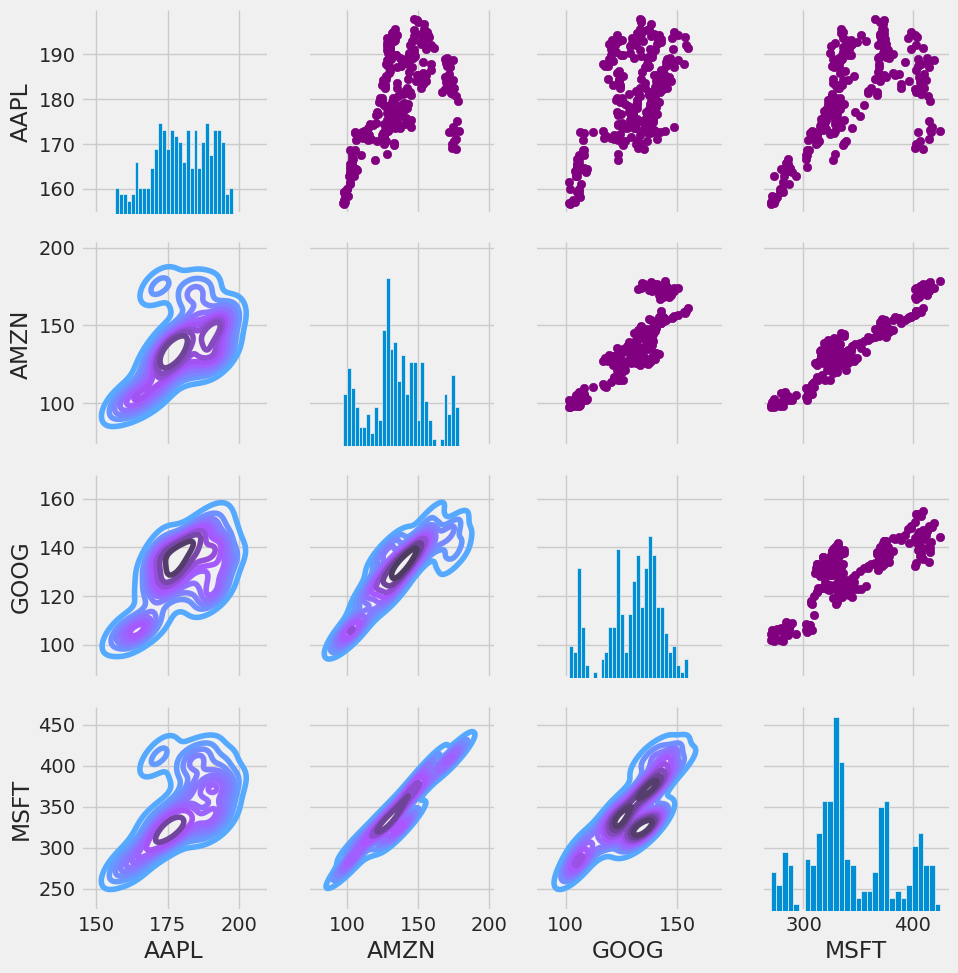

In [18]:

return_fig = sns.PairGrid(tech_rets.dropna())

return_fig.map_upper(plt.scatter, color='purple')

return_fig.map_lower(sns.kdeplot, cmap='cool_d')

return_fig.map_diag(plt.hist, bins=30)
returns_fig = sns.PairGrid(closing_df)

returns_fig.map_upper(plt.scatter,color='purple')

returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

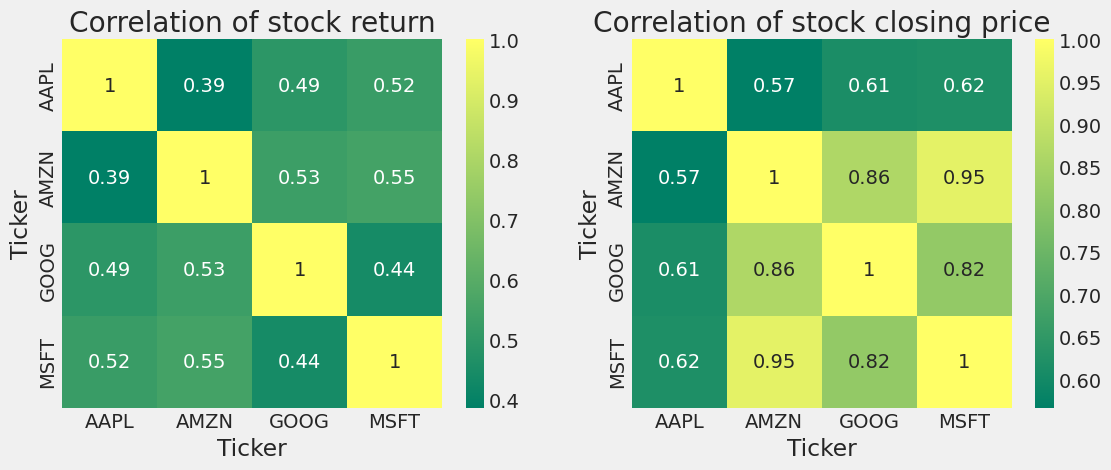

In [19]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

In [20]:
#5. How much value do we put at risk by investing in a particular stock?

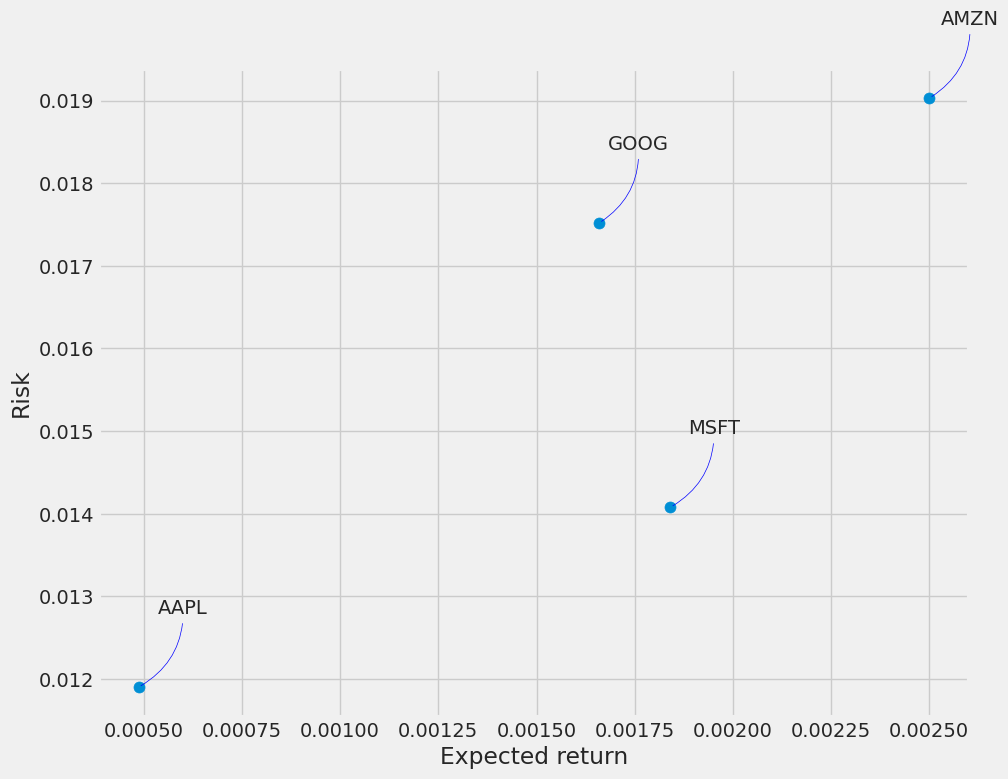

In [21]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [22]:
#6. Predicting the closing price stock price of APPLE inc:

In [23]:

df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433825,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500644,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639426,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771561,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751300,394024400
...,...,...,...,...,...,...
2024-03-12,173.149994,174.029999,171.009995,173.229996,173.229996,59825400
2024-03-13,172.770004,173.190002,170.759995,171.130005,171.130005,52488700
2024-03-14,172.910004,174.309998,172.050003,173.000000,173.000000,72913500


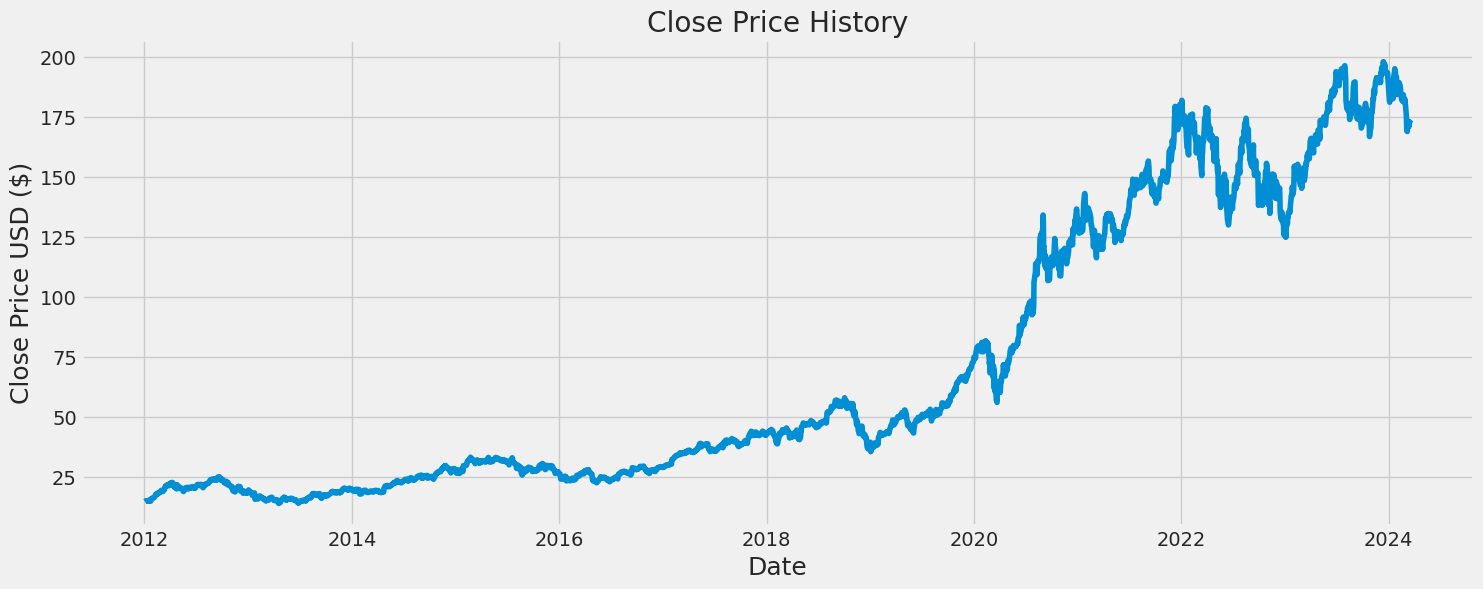

In [24]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [25]:

data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

2918

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.86365302],
       [0.8615896 ],
       [0.86756262]])

In [27]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.0

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

2858/2858 [==============================] - 190s 63ms/step - loss: 0.0015


In [30]:

test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 3s 38ms/step


6.464023829211955

<ipython-input-31-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


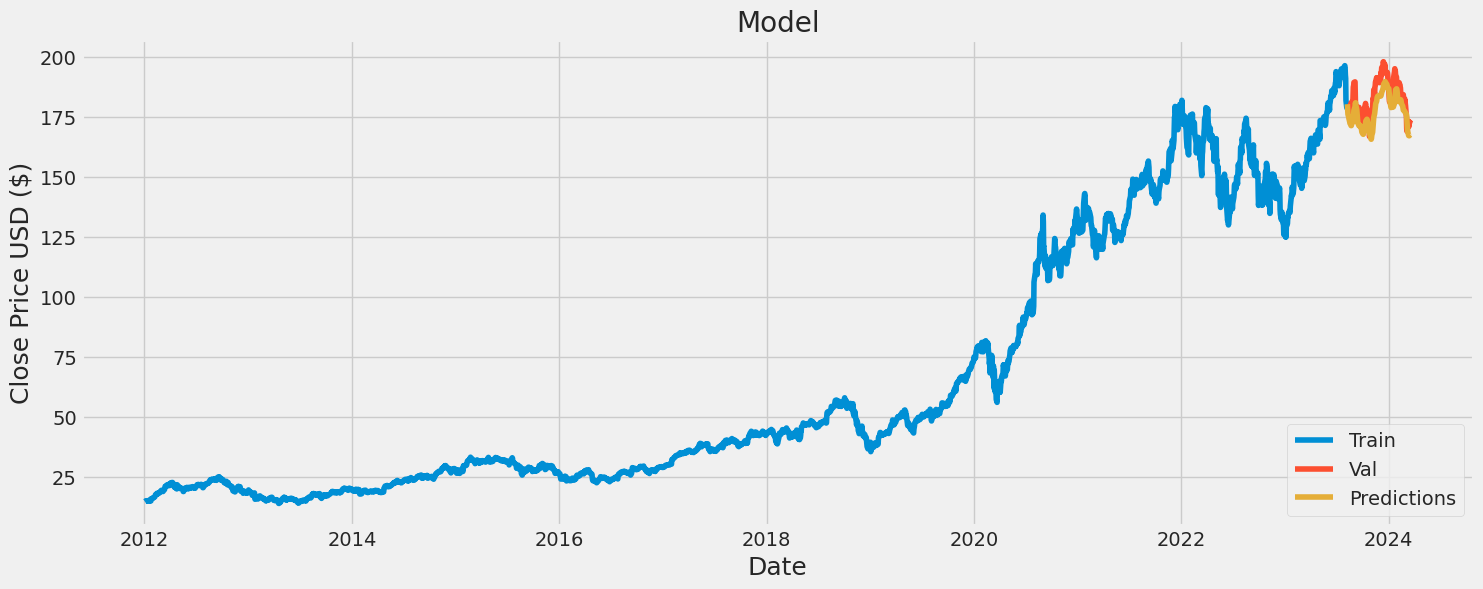

In [31]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [32]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-08-09,178.190002,180.374344
2023-08-10,177.970001,178.054733
2023-08-11,177.789993,176.179810
2023-08-14,179.460007,174.796371
2023-08-15,177.449997,174.109207
...,...,...
2024-03-12,173.229996,167.284439
2024-03-13,171.130005,167.242294
2024-03-14,173.000000,167.210251
